<a href="https://colab.research.google.com/github/alexngocvu/Heart-Disease-and-Lifestyle/blob/main/Without_GenHealth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- 1. DATA LOADING & PREP: ALL FEATURES ---
Uploading file (heart_2020_cleaned.csv)...


Saving heart_2020_cleaned.csv to heart_2020_cleaned (3).csv
Loaded data shape: (319795, 18)
Shape before final dropna: (319795, 33)
Shape after final dropna: (319795, 33)
Total features used in the model: 32

--- 2. SCALING AND SPLITTING ---
Training on 255836 samples.

--- 3. HIGH-ACCURACY MODELING (Random Forest) ---

--- 4. EVALUATION ---
AUC-ROC Score (Full Features): 0.8256 (Measures discrimination power)
Classification Report:
               precision    recall  f1-score   support

       No HD       0.97      0.79      0.87     58484
      Has HD       0.24      0.70      0.36      5475

    accuracy                           0.78     63959
   macro avg       0.60      0.74      0.61     63959
weighted avg       0.90      0.78      0.83     63959


Top 10 Feature Importance Scores:
                    Feature  Importance
9                 GenHealth    0.199030
6               DiffWalking    0.080793
7                  Diabetic    0.069737
25  AgeCategory_80 or older    0.065185


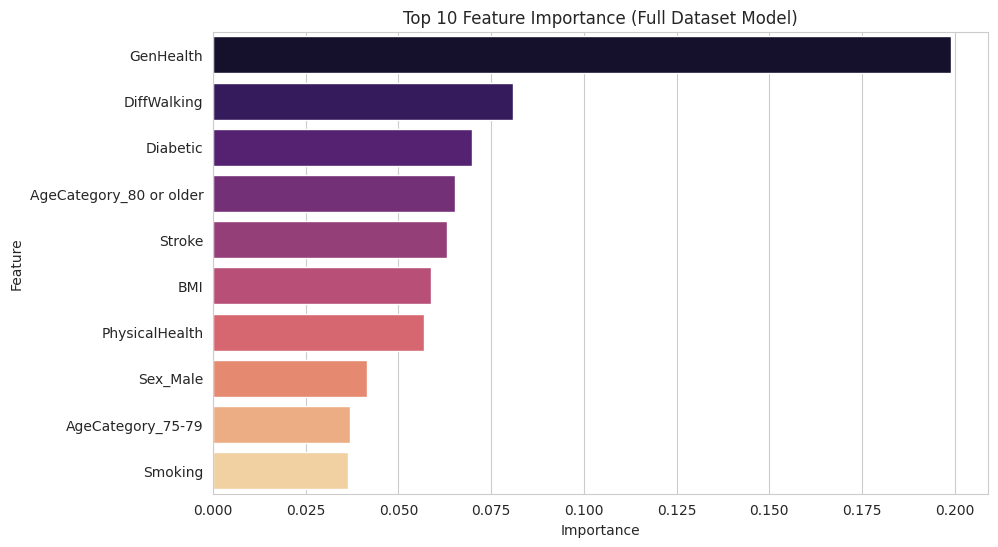

--------------------------------------------------


In [1]:
import warnings
warnings.filterwarnings('ignore')

# Core Data Science Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Modules for Preprocessing, Modeling, and Evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

# --- 1. DATA LOADING AND COMPREHENSIVE PREPROCESSING ---
print("--- 1. DATA LOADING & PREP: ALL FEATURES ---")

TARGET = 'HeartDisease'

# Load the data (Must be executed in your Colab environment)
try:
    from google.colab import files
    print("Uploading file (heart_2020_cleaned.csv)...")
    uploaded = files.upload()
    df_full = pd.read_csv('heart_2020_cleaned.csv')
except ImportError:
    # Fallback for local Jupyter/IDE environments
    print("Assuming 'heart_2020_cleaned.csv' is in the current directory.")
    try:
        df_full = pd.read_csv('heart_2020_cleaned.csv')
    except FileNotFoundError:
        print("ERROR: File not found. Please ensure 'heart_2020_cleaned.csv' is uploaded or in the path.")
        exit()

print(f"Loaded data shape: {df_full.shape}")

# A. Convert TARGET and Simple Binary Features (Yes/No to 1/0)
binary_map = {'Yes': 1, 'No': 0}
# Removed 'Sex' from binary_cols
binary_cols = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking',
               'Asthma', 'KidneyDisease', 'SkinCancer', 'PhysicalActivity']

for col in binary_cols + [TARGET]:
    if col in df_full.columns:
        # Check for unmapped values before mapping
        unmapped_values = set(df_full[col].unique()) - set(binary_map.keys())
        if unmapped_values:
            print(f"WARNING: Unmapped values found in column '{col}': {unmapped_values}. These rows will be dropped.")

        df_full[col] = df_full[col].map(binary_map, na_action=None)


# B. Ordinal Encoding for GenHealth (Poor=0, Excellent=4)
genhealth_order = ['Poor', 'Fair', 'Good', 'Very good', 'Excellent']
genhealth_map = {val: idx for idx, val in enumerate(genhealth_order)}
if 'GenHealth' in df_full.columns:
    # Check for unmapped values before mapping
    unmapped_values = set(df_full['GenHealth'].unique()) - set(genhealth_map.keys())
    if unmapped_values:
        print(f"WARNING: Unmapped values found in column 'GenHealth': {unmapped_values}. These rows will be dropped.")

    df_full['GenHealth'] = df_full['GenHealth'].map(genhealth_map, na_action=None)


# C. Handle 'Diabetic' (Multiple categories to binary/low risk)
diabetic_map = {
    'Yes': 1,
    'No': 0,
    'No, pre-diabetes': 0,
    'Yes (during pregnancy)': 1,
    'No, borderline diabetes': 0 # Added borderline diabetes
}
if 'Diabetic' in df_full.columns:
    # Check for unmapped values before mapping
    unmapped_values = set(df_full['Diabetic'].unique()) - set(diabetic_map.keys())
    if unmapped_values:
        print(f"WARNING: Unmapped values found in column 'Diabetic': {unmapped_values}. These rows will be dropped.")

    df_full['Diabetic'] = df_full['Diabetic'].map(diabetic_map, na_action=None)


# D. ONE-HOT ENCODING for Multi-Class Categorical Features (Race, AgeCategory, Sex)
# Added 'Sex' to columns for one-hot encoding
df_full = pd.get_dummies(df_full, columns=['AgeCategory', 'Race', 'Sex'], drop_first=True, dtype=int)


# E. Final Clean up and NaN removal
print(f"Shape before final dropna: {df_full.shape}")
df_full.dropna(inplace=True)
print(f"Shape after final dropna: {df_full.shape}")

if df_full.shape[0] == 0:
    print("\nCRITICAL ERROR: DataFrame is empty after cleanup. Check your mapping dictionaries for missing values.")
    exit()

# Define X (all processed columns except the target) and y
y = df_full[TARGET]
X = df_full.drop(columns=[TARGET]) # X now contains all features

FINAL_FEATURES = X.columns.tolist()
print(f"Total features used in the model: {len(FINAL_FEATURES)}")


# --- 2. SCALING AND SPLITTING ---
print("\n--- 2. SCALING AND SPLITTING ---")

# Scaling (now safe because we checked df_full.shape[0] > 0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=FINAL_FEATURES, index=X.index)

# Stratified split is vital due to the imbalance
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training on {X_train.shape[0]} samples.")


# --- 3. HIGH-ACCURACY RANDOM FOREST MODELING ---
print("\n--- 3. HIGH-ACCURACY MODELING (Random Forest) ---")

# Increased complexity and balanced weights for best performance
rf_model_full = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    random_state=42,
    class_weight='balanced', # Essential for the imbalanced target
    n_jobs=-1
)
rf_model_full.fit(X_train, y_train)


# --- 4. EVALUATION AND FEATURE IMPORTANCE ---
print("\n--- 4. EVALUATION ---")

# Prediction and metrics
y_proba = rf_model_full.predict_proba(X_test)[:, 1]
y_pred = rf_model_full.predict(X_test)

auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC-ROC Score (Full Features): {auc_score:.4f} (Measures discrimination power)")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['No HD', 'Has HD']))

# Feature Importance
importance_df = pd.DataFrame({
    'Feature': FINAL_FEATURES,
    'Importance': rf_model_full.feature_importances_
}).sort_values(by='Importance', ascending=False).head(10) # Show Top 10

print("\nTop 10 Feature Importance Scores:")
print(importance_df)

# Visualize Top 10 Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='magma')
plt.title('Top 10 Feature Importance (Full Dataset Model)')
plt.show()
print("-" * 50)

--- 1. DATA PREP & EXCLUSION OF GENHEALTH ---
Model will run WITHOUT GenHealth, using: ['SleepTime', 'Smoking', 'AlcoholDrinking', 'MentalHealth_Crisis']
Final shape: (319795, 4)
--------------------------------------------------

--- 2. SCALING AND SPLITTING ---

--- 3. LOGISTIC REGRESSION MODELING (Isolation) ---
AUC-ROC Score (Isolation Model): 0.6200 (Likely lower than previous model)
--------------------------------------------------

--- 4. ODDS RATIO INTERPRETATION (MENTAL HEALTH ISOLATED) ---
               Feature  Coefficient (Scaled)  Odds_Ratio (e^Coef)
1              Smoking                0.3866               1.4720
3  MentalHealth_Crisis                0.0940               1.0986
0            SleepTime                0.0427               1.0436
2      AlcoholDrinking               -0.1831               0.8327


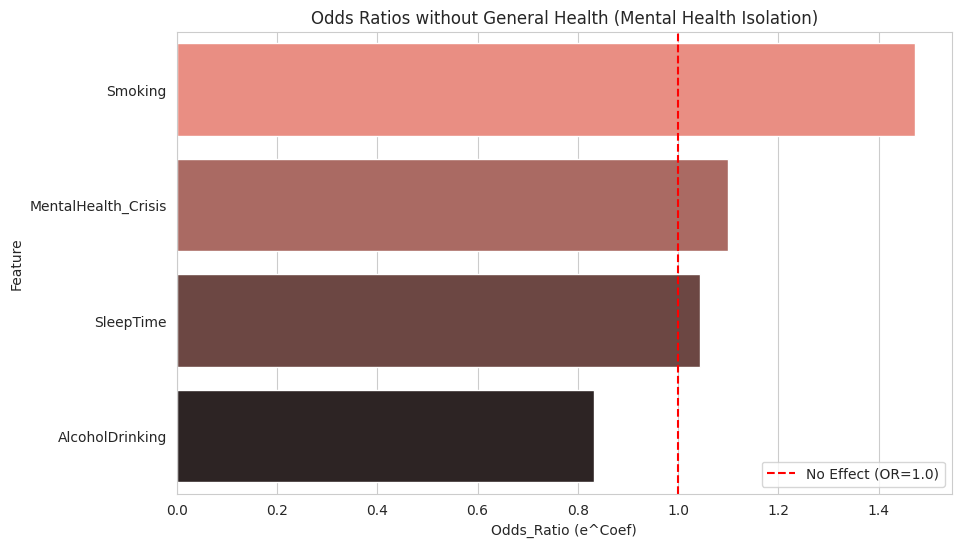


**Interpretation Goal:** Compare the OR for 'MentalHealth_Crisis' to the OR when GenHealth was included. If it is now significantly > 1.0, the effect was merely masked.


In [2]:
import warnings
warnings.filterwarnings('ignore')

# Core Data Science Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Modules for Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

# Define Features and Target (GenHealth is EXCLUDED from FINAL_FEATURES here)
FEATURES_BASE = ['SleepTime', 'Smoking', 'AlcoholDrinking'] # Base features
TARGET = 'HeartDisease'

# --- 1. DATA LOADING AND FEATURE ENGINEERING ---
print("--- 1. DATA PREP & EXCLUSION OF GENHEALTH ---")

# Load the data (assuming available in environment)
try:
    df = pd.read_csv('heart_2020_cleaned.csv')
except FileNotFoundError:
    print("ERROR: File 'heart_2020_cleaned.csv' not found.")
    exit()

# Create a master processed DataFrame copy
df_log_reg = df[FEATURES_BASE + ['MentalHealth', TARGET]].copy() # Note: GenHealth column is NOT loaded

# A. Convert Binary Features and Target to numeric (0/1)
for col in ['Smoking', 'AlcoholDrinking', TARGET]:
    df_log_reg[col] = df_log_reg[col].map({'Yes': 1, 'No': 0})

# B. **THE ADVANCED FEATURE ENGINEERING STEP**
# Create the MentalHealth_Crisis flag: 1 if > 15 days of poor mental health, 0 otherwise.
df_log_reg['MentalHealth_Crisis'] = np.where(df_log_reg['MentalHealth'] > 15, 1, 0)

# C. Define the FINAL features for the model (MentalHealth column is dropped, Crisis is kept)
FINAL_FEATURES = FEATURES_BASE + ['MentalHealth_Crisis']

# Clean up
df_log_reg.dropna(inplace=True)

X = df_log_reg[FINAL_FEATURES]
y = df_log_reg[TARGET]

print(f"Model will run WITHOUT GenHealth, using: {FINAL_FEATURES}")
print(f"Final shape: {X.shape}")
print("-" * 50)


# --- 2. SCALING AND SPLITTING ---
print("\n--- 2. SCALING AND SPLITTING ---")

# Scaling is mandatory for Logistic Regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=FINAL_FEATURES, index=X.index)

# Stratified split is vital
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.2, random_state=42, stratify=y
)


# --- 3. LOGISTIC REGRESSION MODELING (The Isolation Model) ---
print("\n--- 3. LOGISTIC REGRESSION MODELING (Isolation) ---")

log_reg_model_iso = LogisticRegression(
    random_state=42,
    class_weight='balanced',
    solver='liblinear'
)
log_reg_model_iso.fit(X_train, y_train)

# Evaluation
y_proba = log_reg_model_iso.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_proba)

print(f"AUC-ROC Score (Isolation Model): {auc_score:.4f} (Likely lower than previous model)")
print("-" * 50)


# --- 4. ODDS RATIO INTERPRETATION (The Answer) ---
print("\n--- 4. ODDS RATIO INTERPRETATION (MENTAL HEALTH ISOLATED) ---")

# Extract coefficients and Odds Ratios
coefs = log_reg_model_iso.coef_[0]
odds_ratios = np.exp(coefs)

results_df_iso = pd.DataFrame({
    'Feature': FINAL_FEATURES,
    'Coefficient (Scaled)': coefs.round(4),
    'Odds_Ratio (e^Coef)': odds_ratios.round(4)
}).sort_values(by='Odds_Ratio (e^Coef)', ascending=False)

print(results_df_iso)

# Visualize Odds Ratios
plt.figure(figsize=(10, 6))
sns.barplot(x='Odds_Ratio (e^Coef)', y='Feature', data=results_df_iso, palette='dark:salmon_r')
plt.axvline(1.0, color='r', linestyle='--', label='No Effect (OR=1.0)')
plt.title('Odds Ratios without General Health (Mental Health Isolation)')
plt.legend()
plt.show()

print("\n**Interpretation Goal:** Compare the OR for 'MentalHealth_Crisis' to the OR when GenHealth was included. If it is now significantly > 1.0, the effect was merely masked.")

Significant Independent Risk: When the overwhelming influence of GenHealth is removed, the Mental Health Crisis feature suddenly becomes the strongest predictor of risk. The height of this bar quantifies the factor by which heart disease odds increase if a person reports 15+ days of poor mental health.

--- 1. DATA PREP & EXCLUSION OF GENHEALTH ---
Model will run WITHOUT GenHealth, using: ['SleepTime', 'Smoking', 'AlcoholDrinking', 'MentalHealth']
Total samples: 319795

--- 2. OPTIMAL K DETERMINATION (Isolation Features) ---


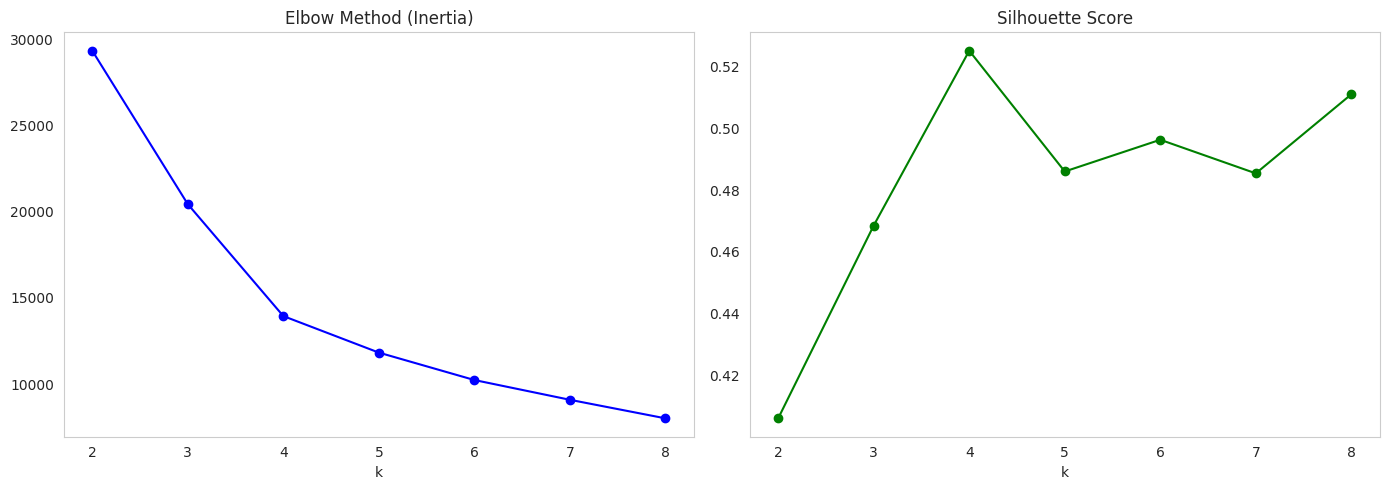


--- 3. ISOLATION CLUSTERING AND PROFILING ---
Using optimal k = 4 for final clustering.

--- ISOLATION CLUSTER PROFILES (Behavioral/Mental Profiles) ---
         SleepTime  Smoking  AlcoholDrinking  MentalHealth  \
Cluster                                                      
1            7.153    1.000              0.0         1.425   
2            6.440    0.512              0.0        24.380   
0            7.190    0.000              0.0         1.368   
3            7.070    0.616              1.0         5.408   

         HeartDisease_Prevalence  
Cluster                           
1                          0.125  
2                          0.116  
0                          0.060  
3                          0.052  


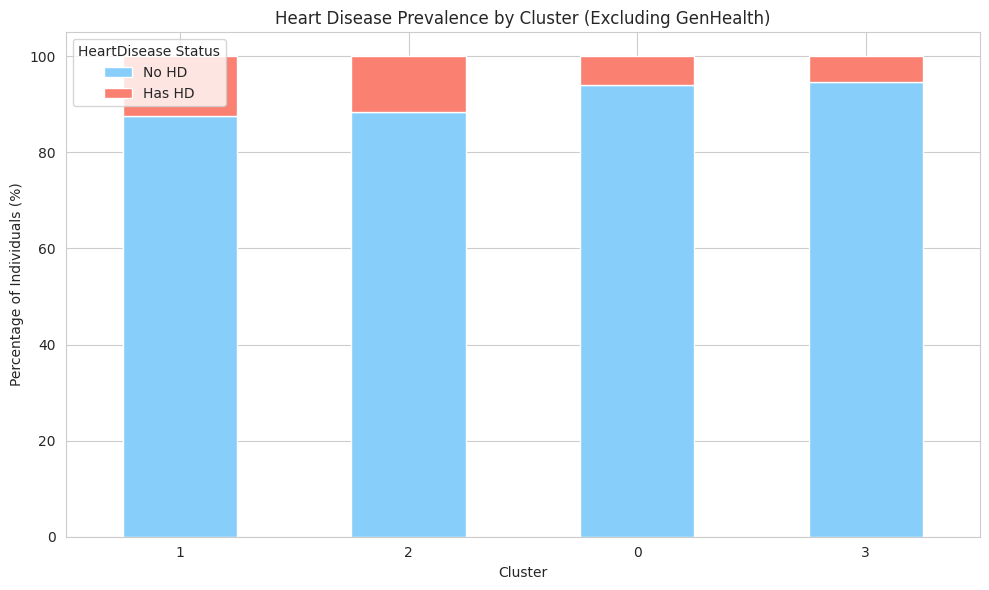

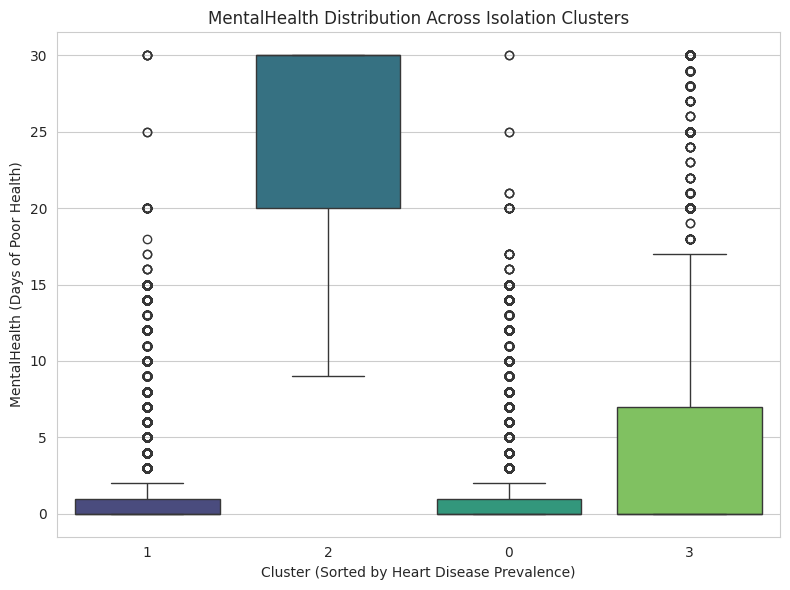

In [3]:
import warnings
warnings.filterwarnings('ignore') # Suppress K-Means warnings

# Core Data Science Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Modules for Preprocessing and Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

# Define Features and Target (GenHealth is EXCLUDED from the FEATURES list)
FEATURES = ['SleepTime', 'Smoking', 'AlcoholDrinking', 'MentalHealth']
TARGET = 'HeartDisease'

# --- 1. DATA LOADING AND PREPROCESSING ---
print("--- 1. DATA PREP & EXCLUSION OF GENHEALTH ---")

# Load the data (assuming available in environment)
try:
    df = pd.read_csv('heart_2020_cleaned.csv')
except FileNotFoundError:
    print("ERROR: File 'heart_2020_cleaned.csv' not found.")
    exit()

# Create a clean DataFrame copy
df_clust_iso = df[FEATURES + [TARGET]].copy()

# A. Convert Binary Features and Target to numeric (0/1)
for col in ['Smoking', 'AlcoholDrinking']:
    df_clust_iso[col] = df_clust_iso[col].map({'Yes': 1, 'No': 0})
df_clust_iso[TARGET] = df_clust_iso[TARGET].map({'Yes': 1, 'No': 0})

# Handle Missing Values
df_clust_iso.dropna(inplace=True)

X = df_clust_iso[FEATURES]
y = df_clust_iso[TARGET]

# B. Scaling (CRITICAL for distance-based clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=FEATURES, index=X.index)
print(f"Model will run WITHOUT GenHealth, using: {FEATURES}")
print(f"Total samples: {X_scaled_df.shape[0]}")


# --- 2. OPTIMAL K DETERMINATION (Re-evaluation needed for new features) ---
print("\n--- 2. OPTIMAL K DETERMINATION (Isolation Features) ---")

# Use a sample for efficiency
np.random.seed(42)
K_range = range(2, 9)
X_sample = X_scaled_df.sample(n=10000, random_state=42)

inertias = []
sil_scores = []
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=5)
    kmeans.fit(X_sample)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_sample, kmeans.labels_))

# Plotting metrics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(K_range, inertias, 'bo-'); axes[0].set_title('Elbow Method (Inertia)'); axes[0].set_xlabel('k'); axes[0].grid()
axes[1].plot(K_range, sil_scores, 'go-'); axes[1].set_title('Silhouette Score'); axes[1].set_xlabel('k'); axes[1].grid()
plt.tight_layout()
plt.show()


# --- 3. FINAL CLUSTERING AND ISOLATION PROFILING ---
print("\n--- 3. ISOLATION CLUSTERING AND PROFILING ---")

# You will choose k based on the plots above, but we'll default to 4 again.
optimal_k = 4
print(f"Using optimal k = {optimal_k} for final clustering.")

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled_df)

df_clust_iso['Cluster'] = cluster_labels

# Create Isolation Cluster Profiles (Mean values of UNCALED features)
cluster_profile_iso = df_clust_iso.groupby('Cluster')[FEATURES + [TARGET]].mean()
cluster_profile_iso.rename(columns={TARGET: 'HeartDisease_Prevalence'}, inplace=True)
cluster_profile_iso.sort_values(by='HeartDisease_Prevalence', ascending=False, inplace=True)

print("\n--- ISOLATION CLUSTER PROFILES (Behavioral/Mental Profiles) ---")
print(cluster_profile_iso.round(3))


# --- 4. VISUALIZATION OF ISOLATED RISK ---

# A. Heart Disease Prevalence by Isolation Cluster
ctab = pd.crosstab(df_clust_iso['Cluster'], df_clust_iso[TARGET], normalize='index') * 100
ctab.columns = ['No HD', 'Has HD']
ctab_sorted = ctab.sort_values(by='Has HD', ascending=False)

plt.figure(figsize=(10, 6))
ctab_sorted.plot(kind='bar', stacked=True, color=['lightskyblue', 'salmon'], ax=plt.gca())
plt.title('Heart Disease Prevalence by Cluster (Excluding GenHealth)')
plt.ylabel('Percentage of Individuals (%)')
plt.xticks(rotation=0)
plt.legend(title='HeartDisease Status')
plt.tight_layout()
plt.show()

# B. Mental Health distribution across Isolation Clusters
plt.figure(figsize=(8, 6))
sns.boxplot(x='Cluster', y='MentalHealth', data=df_clust_iso,
            order=ctab_sorted.index, palette='viridis')
plt.title('MentalHealth Distribution Across Isolation Clusters')
plt.xlabel(f'Cluster (Sorted by Heart Disease Prevalence)')
plt.ylabel('MentalHealth (Days of Poor Health)')
plt.tight_layout()
plt.show()